## Import Packages and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# Load Dataset

df = pd.read_csv('gs://sean_sullivan_projects/MLB_EVOE_Project/January_2022_Data/data_for_clusters.csv')

df.shape

(526, 28)

In [3]:
# columns

df.columns

Index(['fangraphs_id', 'name_last', 'name_first', 'team', 'g', 'ab', 'pa', 'h',
       '_1B', '_2B', '_3B', 'HR', 'R', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'AVG',
       'OBP', 'SLG', 'OPS', 'ISO', 'BABIP', 'wOBA', 'wRAA', 'wRC',
       'Average_EVOE'],
      dtype='object')

In [4]:
# Filter for > 100 PAs

df = df[df['ab'] >= 100]

df.shape

(450, 28)

In [5]:
# Let's remove identifiers

df_cluster = df[['g', 'ab', 'pa', 'h','_1B', '_2B', '_3B', 'HR', 'R', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'AVG', 'OBP', 'SLG', 'OPS', 'ISO', 'BABIP', 
                 'wOBA', 'wRAA', 'wRC', 'Average_EVOE']]


df_ids = df[['fangraphs_id', 'name_last', 'name_first', 'team']]    

In [12]:
df_cluster.shape

(450, 24)

<br>

### Now that data is ready, we need to normalize the data that will be clustered.

In [6]:
# NORMALIZE Data

min_max_scaler = MinMaxScaler().fit(df_cluster)

dfNorm= min_max_scaler.transform(df_cluster)

<br>

### Use PCA to reduce dimensionality

In [7]:
pca = PCA()
pca.fit(dfNorm)

PCA()

In [14]:
# Explained variance

pca.explained_variance_ratio_.cumsum()

array([0.67914363, 0.7890411 , 0.85770705, 0.89119416, 0.91354974,
       0.93150963, 0.94883759, 0.96355177, 0.9729309 , 0.98094106,
       0.98769881, 0.99168429, 0.99522347, 0.99689326, 0.99836176,
       0.99930519, 0.999962  , 0.99998767, 0.99999403, 0.99999742,
       0.99999895, 0.99999963, 1.        , 1.        ])

Text(0, 0.5, 'Cumulative Explained Variance')

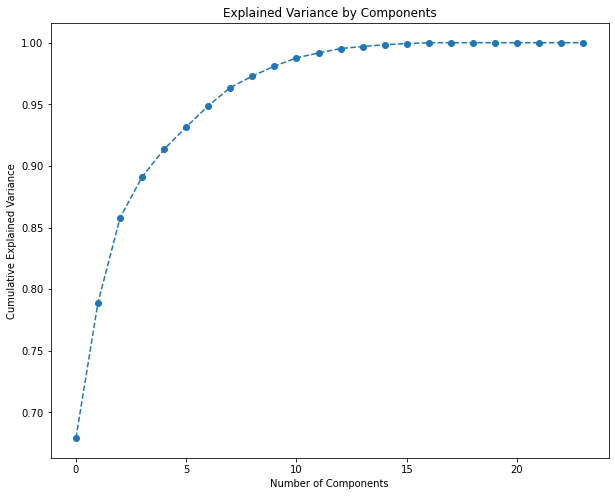

In [11]:
# Visualize

plt.figure(figsize = (10,8))
plt.plot(pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [15]:
# Fitting PCA with chosen # of components

pca = PCA(n_components = 3)
pca.fit(dfNorm)

scores_pca = pca.transform(dfNorm)

<br>
<br>
<br>

## Determine optimal number of clusters

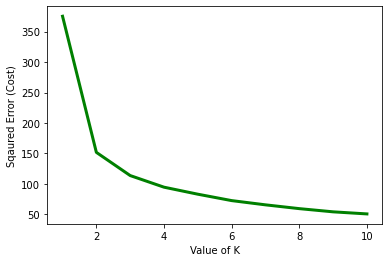

In [16]:
#Function
def cluster_sizes(clusters):
    #clusters is an array of cluster labels for each instance in the data
    
    size = {}
    cluster_labels = np.unique(clusters)
    n_clusters = cluster_labels.shape[0]

    for c in cluster_labels:
        size[c] = len(df[clusters == c])
    return size



cost =[] 
for i in range(1, 11): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(scores_pca) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

**Interpretation:**

Using the "elbow method", I look for where the cost begins to quickly decline. This tends to look like an elbow, hence the "elbow method". In this case, this appears to happen around k = 3 or 4. So, I will begin with using 4 clusters for this analysis.

<br>

## Cluster Sizes and Visualization

In [26]:
# Using 4 clusters

kmeans = KMeans(n_clusters=4, max_iter=500)
kmeans.fit(scores_pca)
clusters = kmeans.predict(scores_pca)

size = cluster_sizes(clusters)

for c in size.keys():
    print("Size of Cluster", c, "= ", size[c])

Size of Cluster 0 =  81
Size of Cluster 1 =  142
Size of Cluster 2 =  135
Size of Cluster 3 =  92


Text(0, 0.5, 'At Bat Count')

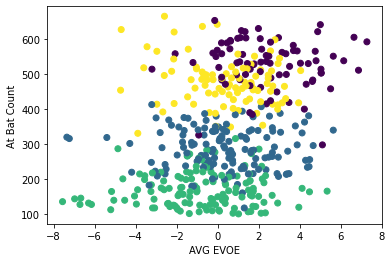

In [27]:
# Visualize Clusters with Average EVOE x At Bats

plt.scatter(df_cluster['Average_EVOE'], df_cluster['ab'], c=clusters)
plt.xlabel("AVG EVOE") 
plt.ylabel("At Bat Count")

Text(0, 0.5, 'Weight Runs Created')

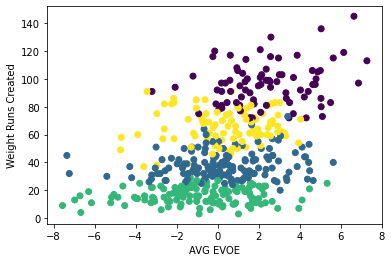

In [28]:
# Visualize Clusters with Average EVOE x wRC

plt.scatter(df_cluster['Average_EVOE'], df_cluster['wRC'], c=clusters)
plt.xlabel("AVG EVOE") 
plt.ylabel("Weight Runs Created")

**Interpretation:**

Visualizing the clusters with Average EVOE x At Bats shows distinct groupings. There is some overlap, which isn't surprised since we are only cutting the clusters by two variables. Looking at Average EVOE x wRC shows less overlap. It's worth exploring the Cluster with the lowest AB's to see who may be over-indexing on Average EVOE compared to the group. Those players could be candidates for extending playing time. 

<br>

## Add cluster assignment to DF and determine which cluster is which

In [29]:
df['cluster'] = clusters

In [30]:
df.head()

,fangraphs_id,name_last,name_first,team,g,ab,pa,h,_1B,_2B,_3B,HR,R,RBI,BB,IBB,SO,HBP,AVG,OBP,SLG,OPS,ISO,BABIP,wOBA,wRAA,wRC,Average_EVOE,cluster
0,17350,devers,rafael,BOS,156,591,664,165,89,37,1,38,101,113,62,7,143,7,0.279,0.352,0.538,0.890,0.259,0.307,0.373,32.2,113,7.27,0
1,4949,stanton,giancarlo,NYY,139,510,579,139,85,19,0,35,64,97,63,1,157,3,0.273,0.354,0.516,0.870,0.243,0.324,0.370,26.4,97,6.86,0
2,19611,guerrero,vladimir,TOR,161,604,698,188,110,29,1,48,123,111,86,7,110,6,0.311,0.401,0.601,1.002,0.290,0.313,0.419,60.4,145,6.64,0
3,19755,ohtani,shohei,LAA,158,537,639,138,58,26,8,46,103,100,96,20,189,4,0.257,0.372,0.592,0.965,0.335,0.303,0.393,41.8,119,6.14,0
4,15640,judge,aaron,NYY,148,550,633,158,95,24,0,39,89,98,75,2,158,3,0.287,0.373,0.544,0.916,0.256,0.332,0.387,38.0,115,5.63,0


In [31]:
# Print Statements

print('Cluster 0 mean EVOE: ', round(df[df['cluster'] == 0].Average_EVOE.mean(),2))
print('Cluster 1 mean EVOE: ', round(df[df['cluster'] == 1].Average_EVOE.mean(),2))
print('Cluster 2 mean EVOE: ', round(df[df['cluster'] == 2].Average_EVOE.mean(),2))
print('Cluster 3 mean EVOE: ', round(df[df['cluster'] == 3].Average_EVOE.mean(),2))
print()
print('Cluster 0 mean At Bats: ', round(df[df['cluster'] == 0].ab.mean(),2))
print('Cluster 1 mean At Bats: ', round(df[df['cluster'] == 1].ab.mean(),2))
print('Cluster 2 mean At Bats: ', round(df[df['cluster'] == 2].ab.mean(),2))
print('Cluster 3 mean At Bats: ', round(df[df['cluster'] == 3].ab.mean(),2))
print()
print('Cluster 0 mean wRC: ', round(df[df['cluster'] == 0].wRC.mean(),2))
print('Cluster 1 mean wRC: ', round(df[df['cluster'] == 1].wRC.mean(),2))
print('Cluster 2 mean wRC: ', round(df[df['cluster'] == 2].wRC.mean(),2))
print('Cluster 3 mean wRC: ', round(df[df['cluster'] == 3].wRC.mean(),2))

Cluster 0 mean EVOE:  2.37
Cluster 1 mean EVOE:  0.32
Cluster 2 mean EVOE:  -0.81
Cluster 3 mean EVOE:  0.42

Cluster 0 mean At Bats:  527.11
Cluster 1 mean At Bats:  285.68
Cluster 2 mean At Bats:  168.48
Cluster 3 mean At Bats:  476.17

Cluster 0 mean wRC:  95.8
Cluster 1 mean wRC:  38.22
Cluster 2 mean wRC:  16.41
Cluster 3 mean wRC:  65.9


<br>

**Interpretation:**

From evaluating each cluster's mean values for Average EVOE, At Bats, and wRC, we can determine which colors belong to each cluster. 

Cluster 0 can be deemed "The High Performers". They get the most opportunities to hit (at bats), have the best average wRC, and have the highest Average EVOE. 

Cluster 3 is "The Middle Ground". They get the second most amount of opportunities to hit, have the second best average wRC, and have the second highest Average EVOE. 

Cluster 1 is the "Are of Opportunity" group. Their Average EVOE is not far off from "The Middle Ground", but their wRC is quite poor. I would further explore this group.

Cluster 2 is "The Bottom of the Barrel". Simply put, they have the lowest values for each of these metrics. 

<br>

In [32]:
# Push File to GCS

df.to_csv('gs://sean_sullivan_projects/MLB_EVOE_Project/January_2022_Data/results_2021_clusters_030622.csv')